# Truncating Infinite Markov Chains - What is a sufficiently large bound?

In order to numerically analyse an infinite Markov chain, we generally analyse a finite version of it, bounding the state space, that is truncating the state space. We want to choose this bound such that the analysis on the truncated Markov chain is very close to analysis that would be done on the infinite Markov chain. So we'd like to cut out states with a very very low probability of visiting them. But also weird things happen on the boundary itself, as we aren't modelling the infinite system here anymore, so we'd like that there is a very very low probability of ever visiting the boundary.

Therefore we'd like ways to find the probability of visiting the boundary.

## Notation

+ Let $P$ denote the transition matrix for a discrete-time Markov chain (DTMC).
+ Let $Q$ denote the transition rate matrix for a continuous-time Markov chain (CTMC).

# Transient Markov chains

For transient Markov chains, we can find the steady-state distribution by:

+ $\pi P = \pi$ and $\sum \pi = 1$ for DTMCs
+ $\pi Q = 0$ and $\sum \pi = 1$ for CTMCs

In [1]:
import numpy as np

In [2]:
def find_steady_state_probs_DTMC(transition_matrix, state_space):
    """
    Finds the steady state probabilities by solving:
    \pi P = \pi
    \sum \pi = 1
    """
    size_mat = len(state_space)
    A = np.append(transition_matrix.transpose() - np.identity(size_mat), np.ones((1, size_mat)), axis=0)
    b = np.hstack((np.transpose(np.zeros(3)), [1]))
    sol = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))
    probs = {state_space[i]: sol[i] for i in range(size_mat)}
    return probs

_TEST:_

Example from Stewart book (pp.205):

\\[
P = \begin{pmatrix}
0.8 & 0.15 & 0.05 \\
0.7 & 0.2 & 0.1 \\
0.5 & 0.3 & 0.2
\end{pmatrix}
\\]

\\[
\pi = (0.76250, 0.16875, 0.06875)
\\]

In [3]:
P = np.array(
    [
        [0.8, 0.15, 0.05],
        [0.7, 0.2, 0.1],
        [0.5, 0.3, 0.2]
    ]
)
find_steady_state_probs_DTMC(transition_matrix=P, state_space=range(3))

{0: 0.7625000000000001, 1: 0.16874999999999996, 2: 0.06874999999999998}

In [4]:
def find_steady_state_probs_CTMC(transition_rate_matrix, state_space):
    """
    Finds the steady state probabilities by solving:
    \pi Q = 0
    \sum \pi = 1
    """
    size_mat = len(state_space)
    A = np.vstack((transition_rate_matrix.transpose()[:-1], np.ones(size_mat)))
    b = np.vstack((np.zeros((size_mat - 1, 1)), [1]))
    sol = np.linalg.solve(A, b).transpose()[0]
    probs = {state_space[i]: sol[i] for i in range(size_mat)}
    return probs

_TEST:_

Example from Stewart book (pp.264):

\\[
Q = \begin{pmatrix}
-4 & 4 & 0 & 0 \\
3 & -6 & 3 & 0 \\
0 & 2 & -4 & 2 \\
0 & 0 & 1 & -1
\end{pmatrix}
\\]

\\[
\pi = (0.12, 0.16, 0.24, 0.48)
\\]

In [5]:
Q = np.array(
    [
        [-4, 4, 0, 0],
        [3, -6, 3, 0],
        [0, 2, -4, 2],
        [0, 0, 1, -1]
    ]
)
find_steady_state_probs_CTMC(Q, range(4))

{0: 0.12, 1: 0.16, 2: 0.24000000000000002, 3: 0.48000000000000004}

### How does this help with truncation?
If we have chosen a sufficiently large boundary, then the probability of being at the boundary in steady state should be very very small.

_Example:_ Consider the Markov chain for an M/M/1 queue with arrival rate $\Lambda$ and service rate $\mu$:

\\[
Q = \begin{pmatrix}
-\Lambda & \Lambda & 0 & 0 & 0 & \cdots \\
\mu & -(\Lambda + \mu) & \Lambda & 0 & 0 & \cdots \\
0 & \mu & -(\Lambda + \mu) & \Lambda & 0 & \cdots \\
0 & 0 & \mu & -(\Lambda + \mu) & \Lambda & \cdots \\
0 & 0 & 0 & \mu & -(\Lambda + \mu) & \cdots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & 
\end{pmatrix}
\\]

In [6]:
def make_mm1_matrix(arrival_rate, service_rate, bound):
    """
    Makes the discretised transition matrix for an M/M/1 queue,
    but there is a chance of closure (absorbtion) when the queue is empty.
    """
    transition_matrix = np.zeros((bound, bound))
    for s1 in range(bound):
        for s2 in range(bound):
            delta = s2 - s1
            if delta == 1:
                transition_matrix[s1, s2] = arrival_rate
            if delta == -1:
                transition_matrix[s1, s2] = service_rate
    transition_matrix = transition_matrix -(np.identity(bound) * transition_matrix.sum(axis=1))
    return transition_matrix

_TEST:_

With $\Lambda = 5$, $\mu = 7$, and a boundary of 4, we should get:

\\[
Q = \begin{pmatrix}
-5 & 5 & 0 & 0 \\
7 & -12 & 5 & 0 \\
0 & 7 & -12 & 5 \\
0 & 0 & 7 & -7
\end{pmatrix}
\\]


In [7]:
make_mm1_matrix(arrival_rate=5, service_rate=7, bound=4)

array([[ -5.,   5.,   0.,   0.],
       [  7., -12.,   5.,   0.],
       [  0.,   7., -12.,   5.],
       [  0.,   0.,   7.,  -7.]])

Finding steady state probabilities with a bound of 4 verses finding steady state probabilities with a bound of 20: we see that the probabiltiy of being at the boundary is much smaller with a bigger boundary. And so the bigger Markov chain with the bigger boundary approximates the infinite Markov chain much better.

In [8]:
mm1_bound4 = make_mm1_matrix(arrival_rate=5, service_rate=7, bound=4)
find_steady_state_probs_CTMC(mm1_bound4, range(4))

{0: 0.38626126126126115,
 1: 0.2759009009009008,
 2: 0.197072072072072,
 3: 0.14076576576576572}

In [9]:
mm1_bound20 = make_mm1_matrix(arrival_rate=5, service_rate=7, bound=20)
find_steady_state_probs_CTMC(mm1_bound20, range(20))

{0: 0.2860561790376059,
 1: 0.2043258421697185,
 2: 0.1459470301212275,
 3: 0.10424787865801965,
 4: 0.07446277047001398,
 5: 0.05318769319286713,
 6: 0.03799120942347654,
 7: 0.02713657815962611,
 8: 0.019383270114018657,
 9: 0.013845192938584761,
 10: 0.00988942352756055,
 11: 0.007063873948257543,
 12: 0.005045624248755394,
 13: 0.0036040173205395733,
 14: 0.002574298086099702,
 15: 0.001838784347214079,
 16: 0.0013134173908672057,
 17: 0.0009381552791908676,
 18: 0.000670110913707769,
 19: 0.0004786506526484127}

### What if they cannot ever reach steady state?
If the infinite Markov chain cannot ever reach steady state, because there is a nonzero probability for the state to go off to infinity, then the truncated Markov chain will never be a good model. The truncated Markov chain will reach steady state however. Using the same analysis as above we see that the boundary is the most common state in the truncated Markov chain's steady state.

In [10]:
mm1_bound20 = make_mm1_matrix(arrival_rate=7, service_rate=5, bound=30)
find_steady_state_probs_CTMC(mm1_bound20, range(30))

{0: 1.652863032049703e-05,
 1: 2.3140082448695842e-05,
 2: 3.239611542817418e-05,
 3: 4.535456159944385e-05,
 4: 6.349638623922138e-05,
 5: 8.889494073490993e-05,
 6: 0.0001244529170288739,
 7: 0.00017423408384042345,
 8: 0.00024392771737659285,
 9: 0.00034149880432722996,
 10: 0.000478098326058122,
 11: 0.0006693376564813708,
 12: 0.0009370727190739191,
 13: 0.0013119018067034866,
 14: 0.0018366625293848814,
 15: 0.0025713275411388343,
 16: 0.003599858557594368,
 17: 0.0050398019806321154,
 18: 0.007055722772884962,
 19: 0.009878011882038946,
 20: 0.013829216634854525,
 21: 0.019360903288796336,
 22: 0.02710526460431487,
 23: 0.037947370446040816,
 24: 0.053126318624457144,
 25: 0.07437684607424,
 26: 0.104127584503936,
 27: 0.1457786183055104,
 28: 0.20409006562771456,
 29: 0.2857260918788004}

# Absorbing Markov chains

Absorbing Markov chains are those that have at least one state (or set of states) from which it is impossible to escape. Truncation here cannot be analysed in the same way, because the steady state probabilities will always be nonzero for the transient states.

In [11]:
Q = np.array(
    [
        [-6, 3, 1, 2],
        [8, -10, 1, 1],
        [0, 7, -14, 7],
        [0, 0, 0, 0]
    ]
)
find_steady_state_probs_CTMC(Q, range(4))

{0: -0.0, 1: -0.0, 2: -0.0, 3: 1.0}

One way to consider if the bound is sufficiently large is to calculate the KPI of interest for a number of different bounds. At the point where the KPI isn't dependent on the bound, it is sufficiently large.

Let's consider expected time to absorption. If an absorbing CTMC transition rate matrix $Q$ can be written as:

\\[
Q =
\left(\begin{array}{c|c}
A & B \\ \hline
0 & 0
\end{array}\right)
\\]

then the mean time to absorption $\nu$ is found by solving:

\\[
\nu A = e
\\]

where $e$ is the vecotr of ones.

Similarly for DTMC, if the transition matrix $P$ can be written as:

\\[
P =
\left(\begin{array}{c|c}
T & U \\ \hline
0 & V
\end{array}\right)
\\]

then the mean time to absorption $\nu$ is found by solving:

\\[
\nu = (\mathbb{I} - T)^{-1} e
\\]


In [12]:
def find_mean_time_to_absorption_CTMC(transition_rate_matrix, all_states):
    """
    Finds the mean time to absorption from each state
    """
    Q = transition_rate_matrix.copy()
    absorbing_states = [si for si, s in enumerate(all_states) if np.all(Q[si]==0)]
    transient_states = [si for si, s in enumerate(all_states) if si not in absorbing_states]
    n_transient = len(transient_states)
    time2absorb = np.linalg.solve(-Q[:, transient_states][transient_states], np.ones(n_transient))
    mean_times_to_absorption = {all_states[s]: time2absorb[si] for si, s in enumerate(transient_states)}
    return mean_times_to_absorption

_TEST:_

Example from Stewart book (pp.261):

\\[
Q = \begin{pmatrix}
-4 & 4 & 0 & 0 \\
3 & -6 & 2 & 1 \\
0 & 2 & -4 & 2 \\
0 & 0 & 0 & 0
\end{pmatrix}
\\]

\\[
\nu = (1.375, 1.125, 0.8125)
\\]

In [13]:
Q = np.array(
    [
        [-4, 4, 0, 0],
        [3, -6, 2, 1],
        [0, 2, -4, 2],
        [0, 0, 0, 0]
    ]
)
find_mean_time_to_absorption_CTMC(Q, range(4))

{0: 1.375, 1: 1.125, 2: 0.8124999999999999}

In [14]:
def find_mean_time_to_absorption_DTMC(transition_matrix, all_states):
    """
    Finds the mean time to absorption from each state
    """
    P = transition_matrix.copy()
    absorbing_states = [si for si, s in enumerate(all_states) if np.all(P[si, si]==1)]
    transient_states = [si for si, s in enumerate(all_states) if si not in absorbing_states]
    n_transient = len(transient_states)
    time2absorb = np.linalg.solve(np.identity(n_transient)-P[:, transient_states][transient_states], np.ones(n_transient))
    mean_times_to_absorption = {all_states[s]: time2absorb[si] for si, s in enumerate(transient_states)}
    return mean_times_to_absorption

_TEST:_

Example from Stewart book (pp.221--223, modified, slightly by amalgamated many absorbing states):

\\[
P = \begin{pmatrix}
0.4 & 0.2 & 0.0 & 0.4 \\
0.3 & 0.3 & 0.0 & 0.4 \\
0.0 & 0.0 & 0.1 & 0.9 \\
0.0 & 0.0 & 0.0 & 1.0
\end{pmatrix}
\\]

\\[
\nu = (2.5, 2.5, 1.111)
\\]

In [15]:
P = np.matrix(
    [
        [0.4, 0.2, 0.0, 0.4],
        [0.3, 0.3, 0.0, 0.4],
        [0.0, 0.0, 0.1, 0.9],
        [0.0, 0.0, 0.0, 1.0]
    ]
)
find_mean_time_to_absorption_DTMC(P, range(4))

{0: 2.5, 1: 2.5, 2: 1.1111111111111112}

Therefore, one way to consider if a bound is sufficiently large to approximate an infinite Markov chain, is to calculate the time to absorption of the truncated Markov chain for many different boundaries, and see if it doesn't change.

As an example, consider an M/M/1 queue with arrival rate $\Lambda$ and service rate $\mu$, however now if the queue is empty, there is a chance that the whole queue closes business, at rate $\psi$. The Markov chain would look like:

\\[
Q = \begin{pmatrix}
-(\Lambda + \psi) & \Lambda & 0 & 0 & 0 & 0 & \cdots & \psi \\
0 & \mu & -(\Lambda + \mu) & \Lambda & 0 & 0 & \cdots & 0 \\
0 & 0 & \mu & -(\Lambda + \mu) & \Lambda & 0 & \cdots & 0 \\
0 & 0 & 0 & \mu & -(\Lambda + \mu) & \Lambda & \cdots & 0 \\
0 & 0 & 0 & 0 & \mu & -(\Lambda + \mu) &  \cdots & 0 \\
0 & 0 & 0 & 0 & 0 & \mu &  \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
\end{pmatrix}
\\]

In [16]:
def make_modified_mm1_matrix(arrival_rate, service_rate, closure_rate, bound):
    """
    Makes the discretised transition matrix for an M/M/1 queue,
    but there is a chance of closure (absorbtion) when the queue is empty.
    """
    transition_matrix = np.zeros((bound, bound))
    for s1 in range(bound):
        for s2 in range(bound):
            delta = s2 - s1
            if delta == 1:
                transition_matrix[s1, s2] = arrival_rate
            if delta == -1:
                transition_matrix[s1, s2] = service_rate
    new_column = np.hstack(([closure_rate], np.zeros(bound - 1)))
    transition_matrix = np.c_[transition_matrix, new_column]
    transition_matrix = np.vstack((transition_matrix, np.zeros(bound + 1)))
    transition_matrix = transition_matrix -(np.identity(bound + 1) * transition_matrix.sum(axis=1))
    return transition_matrix

_TEST:_

With $\Lambda = 5$, $\mu = 7$, $\psi = 3$ and a boundary of 4, we should get:

\\[
Q = \begin{pmatrix}
-8 & 5 & 0 & 0 & 3 \\
7 & -12 & 5 & 0 & 0 \\
0 & 7 & -12 & 5 & 0 \\
0 & 0 & 7 & -7 & 0 \\
0 & 0 & 0 & 0 & 0
\end{pmatrix}
\\]


In [17]:
make_modified_mm1_matrix(5, 7, 3, 4)

array([[ -8.,   5.,   0.,   0.,   3.],
       [  7., -12.,   5.,   0.,   0.],
       [  0.,   7., -12.,   5.,   0.],
       [  0.,   0.,   7.,  -7.,   0.],
       [  0.,   0.,   0.,   0.,   0.]])

Now let's see how the absorption probabilties behave for different values of boundary.

In [18]:
import matplotlib.pyplot as plt

In [19]:
def plot_absorption_times(arrival_rate, service_rate, closure_rate, min_bound, max_bound):
    absorption_times = {i: [] for i in range(max_bound)}
    
    for bound in range(min_bound, max_bound):
        mm1_rate_matrix = make_modified_mm1_matrix(arrival_rate, service_rate, closure_rate, bound)
        times_to_absorption = find_mean_time_to_absorption_CTMC(mm1_rate_matrix, range(bound + 1))
        for from_state in range(1, max_bound - 1):
            if from_state < bound:
                absorption_times[from_state].append(times_to_absorption[from_state])
            else:
                absorption_times[from_state].append(np.nan)

    fig, ax = plt.subplots(1, figsize=(8, 4))
    colors = plt.cm.viridis(np.linspace(0, 1, int(max_bound / 2) - 1))
    for i, from_state in enumerate(range(1, int(max_bound / 2))):
        ax.plot(range(min_bound, max_bound), absorption_times[from_state], c=colors[i], label=from_state)
    ax.set_xlabel(r'Boundary ($B$)', fontsize=12)
    ax.set_ylabel(r'Mean time to absorption ($\nu_i$)', fontsize=12)
    ax.set_xlim(min_bound, max_bound - 1)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, title=r'Initial State ($i$)', fontsize=12)
    ax.set_title(f'$\Lambda = {arrival_rate}$, $\mu = {service_rate}$, $\psi = {closure_rate}$', fontsize=16)
    return fig

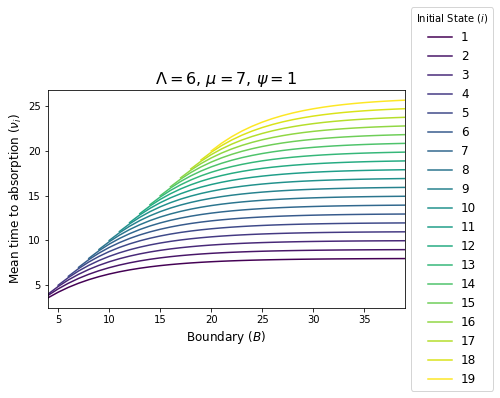

In [20]:
plot_absorption_times(6, 7, 1, 4, 40);

In this case it takes a boundary of around 20-25 before things start absorbtion time doesn't become dependent on the boundary.

What if the Markov chain shoots off to infinity? (we know an M/M/1 queue with $\Lambda > \mu$ will shoot off to infinity); then the mean time to absorption should approach $\infty$, so as the boundary increases the mean time to absorption should now increase, not flatten:

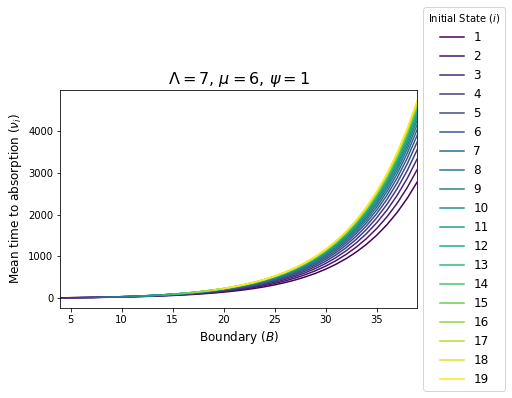

In [21]:
plot_absorption_times(7, 6, 1, 4, 40);

# Note:
However, ***this is very inefficient!***
Here we had to create and solve the truncated Markov chain for each boundary value, and compare them all. This might be difficult to do in reality. We also had to create better solutions to find out if they were good. That is, to find out if a boundary of 15 is good or not, we had to solve for boundaries larger than 15 to see if anything changed.

It would be better if we could just solve once, and determine if the bound is good on not there and then. Just like we did above for the steady-state analysis on transient Markov chains.

Therefore, I propose using:

## Hitting Probability Analyis

The hitting probabilities of an absorbing Markov chain are the probabilities of ever reaching each state, when starting from a given state. Let $h_{ij}$ denote the probability of ever hitting state $j$ if starting from state $i$. It is given by solving:

\\[
h_{ij} = \begin{cases}
    \sum_{k} p_{ik} h_{kj} & i \neq j\\
    1 & i = j
  \end{cases}
\\]

This calculation is usually done when $j$ is an abosrbing state, and we get the absorbtion probabilities. However, we can treat any transient state $j$ as an absorbing state, and we still get the probabilties out.


In [22]:
def find_hitting_probs(transition_matrix, all_states, state):
    """
    Finds the probability of ever reaching a transient state `state' from every transient state.
    """
    P = transition_matrix.copy()
    n_states = len(all_states)
    i = all_states.index(state)
    absorbing_states = [si for si, s in enumerate(all_states) if P[si, si]==1.0]
    transient_states = [si for si, s in enumerate(all_states) if si not in absorbing_states]
    it = transient_states.index(i)
    n_transient = len(transient_states)
    P[i] = np.zeros(n_states)
    A = P[:, transient_states][transient_states] - np.identity(n_transient)
    b = np.zeros(n_transient)
    b[it] = -1
    p = np.linalg.solve(A, b)
    hitting_probabilities = {all_states[s]: p[si] for si, s in enumerate(transient_states)}
    return hitting_probabilities

_TEST:_

Made up example based on the maths of https://youtu.be/edTup9lQU90, but now treating transient states as absorbing states:

\\[
P = \begin{pmatrix}
1/5 & 1/5 & 1/5 & 2/5 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 1/3 & 0 & 1/3 & 1/3 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
1/2 & 0 & 0 & 0 & 0 & 1/2 \\
0 & 0 & 1/2 & 1/4 & 1/4 & 0
\end{pmatrix}
\\]

+ There are two abosrbing states, state 1 and 3, so $h_{10} = h_{30} = 0$ by definition.
+ For $h_{00}$ we are already at state 0, so guaranteed hit, $h_{00} = 1$
+ To find $h_{20}$, $h_{40}$, and $h_{50}$ we solve:
  
  \\[
  \begin{align}
  h_{20} &= \frac{1}{3}h_{10} + \frac{1}{3}h_{30} + \frac{1}{3}h_{40} \\
  h_{40} &= \frac{1}{2}h_{00} + \frac{1}{2}h_{50} \\
  h_{50} &= \frac{1}{2}h_{20} + \frac{1}{4}h_{30} + \frac{1}{4}h_{40}
  \end{align}
  \\]

  which simplifies to:
  
  \\[
  \begin{align}
  h_{20} &= \frac{1}{3}h_{40} \\
  h_{40} &= \frac{1}{2} + \frac{1}{2}h_{50} \\
  h_{50} &= \frac{1}{2}h_{40} + \frac{1}{4}h_{40}
  \end{align}
  \\]
  
+ This gives
  - $h_{20} = \frac{4}{19} = 0.210526$
  - $h_{40} = \frac{12}{19} = 0.631579$
  - $h_{50} = \frac{5}{19} = 0.263158$
  

In [23]:
P = np.array(
    [
        [1/5, 1/5, 1/5, 2/5, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1/3, 0.0, 1/3, 1/3, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [1/2, 0.0, 0.0, 0.0, 0.0, 1/2],
        [0.0, 0.0, 1/2, 1/4, 1/4, 0.0]
    ]
)
find_hitting_probs(P, range(6), 0)

{0: 1.0, 2: 0.21052631578947367, 4: 0.631578947368421, 5: 0.26315789473684204}

Additionally it would be good to be able to do this with CTMCs, so we need to be able to discretise the continuous transition matrix to use in the hitting probabilities function.

In [24]:
def discretise_transition_rate_matrix(transition_rate_matrix):
    """
    Discretises a CTMC rate matrix to a DTMC probabilities matrix
    """
    size_mat = len(transition_rate_matrix)
    time_step = 1 / (-transition_rate_matrix.diagonal()).max()
    transition_matrix = transition_rate_matrix * time_step + np.identity(size_mat)
    return transition_matrix

_TEST:_

Example from Stewart book (pp.286):

\\[
Q = \begin{pmatrix}
-4 & 4 & 0 & 0 \\
3 & -6 & 3 & 0 \\
0 & 2 & -4 & 2 \\
0 & 0 & 1 & -1
\end{pmatrix}
\\]

\\[
P = \begin{pmatrix}
1/3 & 2/3 & 0 & 0 \\
1/2 & 0 & 1/2 & 0 \\
0 & 1/3 & 1/3 & 1/3 \\
0 & 0 & 1/6 & 5/6
\end{pmatrix}
\\]

In [25]:
Q = np.array(
    [
        [-4, 4, 0, 0],
        [3, -6, 3, 0],
        [0, 2, -4, 2],
        [0, 0, 1, -1]
    ]
)
discretise_transition_rate_matrix(Q)

array([[0.33333333, 0.66666667, 0.        , 0.        ],
       [0.5       , 0.        , 0.5       , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.        , 0.16666667, 0.83333333]])

### How does this help with truncation?
If we have chosen a sufficiently large boundary, then the probability of hitting the boundary from a reasonable state (another state not close to the boundary) should be very very small.

Consider again the modified M/M/1 queue with chance of closure. Compare the probabilities of hitting the boundary when the boundary is small (5) and big (45):

In [26]:
mm1_rate_matrix = make_modified_mm1_matrix(6, 7, 1, 5)
mm1_matrix = discretise_transition_rate_matrix(mm1_rate_matrix)
find_hitting_probs(mm1_matrix, range(6), 4) # State 5 the final state is the absorbing state

{0: 0.5397750937109542,
 1: 0.6297376093294467,
 2: 0.734693877551021,
 3: 0.8571428571428575,
 4: 1.0}

We can immediately see that with a boundary of 5 the probability if hitting the boundary is large from any state, and so without running anything else we know this is a bad model.

In [27]:
mm1_rate_matrix = make_modified_mm1_matrix(6, 7, 1, 45)
mm1_matrix = discretise_transition_rate_matrix(mm1_rate_matrix)
find_hitting_probs(mm1_matrix, range(46), 44)  # State 35 the final state is the absorbing state

{0: 0.001133290520922891,
 1: 0.0013221722744100398,
 2: 0.0015425343201447375,
 3: 0.0017996233735018843,
 4: 0.0020995606024185555,
 5: 0.0024494873694880046,
 6: 0.0028577352644023617,
 7: 0.0033340244751357776,
 8: 0.003889695220991429,
 9: 0.004537977757823022,
 10: 0.0052943073841265455,
 11: 0.006176691948147322,
 12: 0.00720614060617156,
 13: 0.008407164040533169,
 14: 0.009808358047288378,
 15: 0.011443084388502786,
 16: 0.013350265119919595,
 17: 0.015575309306572537,
 18: 0.018171194191000967,
 19: 0.02119972655616746,
 20: 0.024733014315528365,
 21: 0.02885518336811608,
 22: 0.03366438059613507,
 23: 0.039275110695490556,
 24: 0.04582096247807195,
 25: 0.053457789557750234,
 26: 0.06236742115070822,
 27: 0.07276199134249253,
 28: 0.0848889898995742,
 29: 0.09903715488283614,
 30: 0.11554334736330837,
 31: 0.1348005719238593,
 32: 0.1572673339111687,
 33: 0.1834785562296963,
 34: 0.2140583156013118,
 35: 0.24973470153486318,
 36: 0.29135715179067306,
 37: 0.3399166770891179,

We can immediately see that with a boundary of 45 the probability if hitting the boundary is small from most states. It's small from most reasonable states, those not close to the boundary itself. And so without running anything else we know this is a good model.

### What if there is a probability of it never reaching the absorbing state?
If the infinite Markov chain has a chance of never reaching the absorbing state, because there is a nonzero probability for the state to go off to infinity, then the truncated Markov chain will never be a good model. The truncated Markov chain will therefore be guaranteed to reach the boundary:

Now to consider the modified M/M/1 matrix:

In [28]:
mm1_rate_matrix = make_modified_mm1_matrix(9, 2, 1, 35)
mm1_matrix = discretise_transition_rate_matrix(mm1_rate_matrix)
find_hitting_probs(mm1_matrix, range(36), 34) # State 34 the final state is the absorbing state

{0: 0.8750000000000018,
 1: 0.9722222222222243,
 2: 0.9938271604938294,
 3: 0.9986282578875193,
 4: 0.9996951684194504,
 5: 0.9999322596487683,
 6: 0.9999849465886167,
 7: 0.9999966547974719,
 8: 0.9999992566216619,
 9: 0.9999998348048152,
 10: 0.9999999632899603,
 11: 0.9999999918422148,
 12: 0.9999999981871601,
 13: 0.9999999995971479,
 14: 0.9999999999104785,
 15: 0.9999999999801074,
 16: 0.9999999999955804,
 17: 0.9999999999990188,
 18: 0.9999999999997828,
 19: 0.9999999999999526,
 20: 0.9999999999999902,
 21: 0.9999999999999986,
 22: 1.0000000000000002,
 23: 1.0000000000000004,
 24: 1.0000000000000004,
 25: 1.0000000000000004,
 26: 1.0000000000000004,
 27: 1.0000000000000004,
 28: 1.0000000000000004,
 29: 1.0000000000000004,
 30: 1.0000000000000004,
 31: 1.0000000000000004,
 32: 1.0000000000000004,
 33: 1.0000000000000002,
 34: 1.0}

This gives us some quick and easy clues to see if the truncated model is a good model or not, and to see whether the states shoot off to infinity or not, by only considering one truncated model

### Some extra plotting for interest:

In [29]:
def plot_boundary_hitting_probs(arrival_rate, service_rate, closure_rate, min_bound, max_bound):
    hitting_probs = {i: [] for i in range(max_bound)}
    absorption_times = {i: [] for i in range(max_bound)}
    
    for bound in range(min_bound, max_bound):
        mm1_rate_matrix = make_modified_mm1_matrix(arrival_rate, service_rate, closure_rate, bound)
        mm1_matrix = discretise_transition_rate_matrix(mm1_rate_matrix)
        times_to_absorption = find_mean_time_to_absorption_CTMC(mm1_rate_matrix, range(bound + 1))
        for from_state in range(1, max_bound - 1):
            if from_state < bound:
                hitting_probs[from_state].append(find_hitting_probs(mm1_matrix, range(bound + 1), bound - 1)[from_state])
                absorption_times[from_state].append(times_to_absorption[from_state])
            else:
                hitting_probs[from_state].append(np.nan)
                absorption_times[from_state].append(np.nan)

    fig, axarr = plt.subplots(2, figsize=(7, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, int(max_bound / 2) - 1))
    for i, from_state in enumerate(range(1, int(max_bound / 2))):
        axarr[0].plot(range(min_bound, max_bound), hitting_probs[from_state], c=colors[i], label=from_state)
        axarr[1].plot(range(min_bound, max_bound), absorption_times[from_state], c=colors[i])
    axarr[0].set_xlabel(r'Boundary ($B$)', fontsize=12)
    axarr[1].set_xlabel(r'Boundary ($B$)', fontsize=12)
    axarr[0].set_ylabel(r'Boundary hitting probability ($h_{iB}$)', fontsize=12)
    axarr[1].set_ylabel(r'Mean time to absorption ($\nu_i$)', fontsize=12)
    axarr[0].set_ylim(0, 1)
    axarr[0].set_xlim(min_bound, max_bound - 1)
    axarr[1].set_xlim(min_bound, max_bound - 1)
    box0 = axarr[0].get_position()
    box1 = axarr[1].get_position()
    axarr[0].set_position([box0.x0, box0.y0, box0.width * 0.8, box0.height])
    axarr[1].set_position([box1.x0, box1.y0, box1.width * 0.8, box1.height])
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0), frameon=True, title=r'Initial State ($i$)', fontsize=12)
    axarr[0].set_title(f'$\Lambda = {arrival_rate}$, $\mu = {service_rate}$, $\psi = {closure_rate}$', fontsize=16)
    return fig

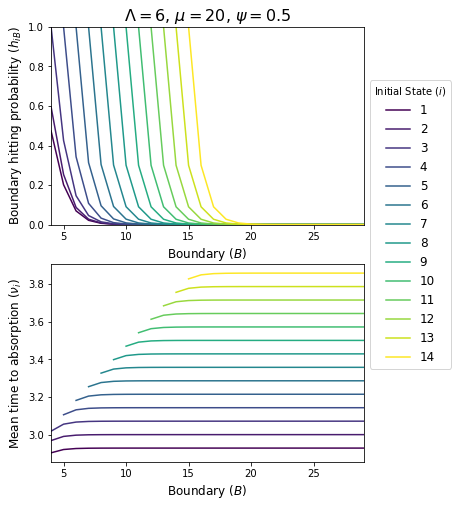

In [30]:
# an example that doesn't need a large boundary
plot_boundary_hitting_probs(6, 20, 0.5, 4, 30);

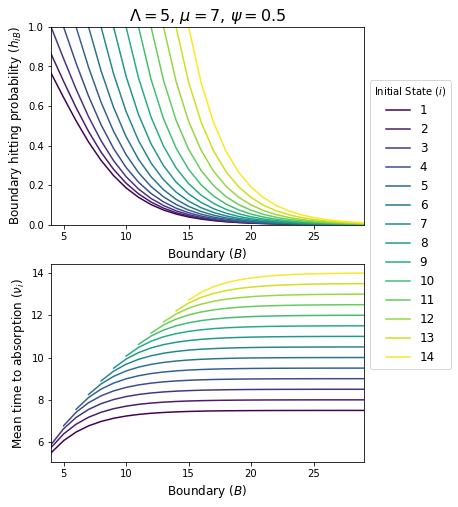

In [31]:
# an example that needs a moderate boundary
plot_boundary_hitting_probs(5, 7, 0.5, 4, 30);

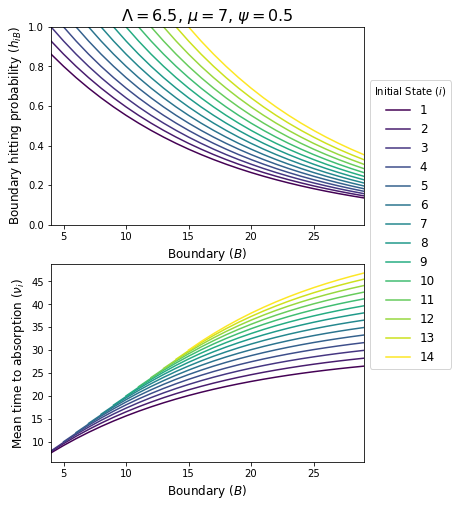

In [32]:
# an example that needs a large boundary
plot_boundary_hitting_probs(6.5, 7, 0.5, 4, 30);

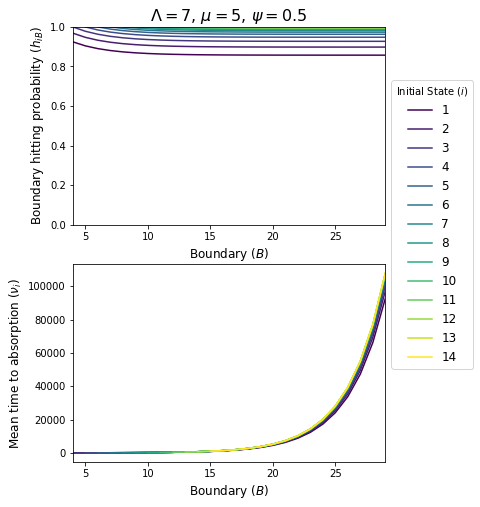

In [33]:
# an example that doesn't necessarily reach the absorbing state
plot_boundary_hitting_probs(7, 5, 0.5, 4, 30);

# Gambler's Ruin

Gambler's ruin is a situation where we have an absorbing infinite Markov chain, but we are always guaranteed to reach the absorbing state, it cannot 'go off to infinity'. There are a few versions, but here I'll consider:

+ A gambler plays a game with a given probability of winning
+ They bet the `state' number, and either they loose everything (ruin), or win and move to the next state.
+ The gambler bets everything they have every time

If the probability of winning is $p$, then the infinite absorbing Markov chain looks like:

\\[
P = \begin{pmatrix}
1 - p & 0 & p & 0 & 0 & 0 & \cdots \\
1 - p & 0 & 0 & p & 0 & 0 & \cdots \\
1 - p & 0 & 0 & 0 & p & 0 & \cdots \\
1 - p & 0 & 0 & 0 & 0 & p & \cdots \\
1 - p & 0 & 0 & 0 & 0 & 0 & \cdots \\
1 - p & 0 & 0 & 0 & 0 & 0 & \cdots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots \\
\end{pmatrix}
\\]

In [34]:
def make_gamblers_ruin_matrix(winning_prob, bound):
    """
    Makes the transition matrix for gamblers ruin:
      - A gambler plays a game with a given chance of winning
      - They bet `state', and their loose everything, or win +1
      - The gambler bets everything they have every time
    """
    transition_matrix = np.zeros((bound, bound))
    for s1 in range(bound):
        for s2 in range(bound):
            delta = s2 - s1
            if s1 == s2 == 0:
                transition_matrix[s1, s2] = 1.0
            elif s1 != 0:
                if delta == 1:
                    transition_matrix[s1, s2] = winning_prob
                if delta == -s1:
                    transition_matrix[s1, s2] = 1 - winning_prob
                if s2 == bound - 1 and s1 in [bound-2, bound-1]:
                    transition_matrix[s1, s2] = winning_prob
    return transition_matrix

_TEST:_

With $p = 0.8$, and a boundary of 6, we should get:

\\[
Q = \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
0.2 & 0 & 0.8 & 0 & 0 & 0 \\
0.2 & 0 & 0 & 0.8 & 0 & 0 \\
0.2 & 0 & 0 & 0 & 0.8 & 0 \\
0.2 & 0 & 0 & 0 & 0 & 0.8 \\
0.2 & 0 & 0 & 0 & 0 & 0.8 \\
\end{pmatrix}
\\]


In [35]:
make_gamblers_ruin_matrix(0.8, 6)

array([[1. , 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0. , 0.8, 0. , 0. , 0. ],
       [0.2, 0. , 0. , 0.8, 0. , 0. ],
       [0.2, 0. , 0. , 0. , 0.8, 0. ],
       [0.2, 0. , 0. , 0. , 0. , 0.8],
       [0.2, 0. , 0. , 0. , 0. , 0.8]])

Now let's use the hitting probability analysis to see that the probability of hitting the boundary is small, and so always absorbs (the gambler is always ruined).

In [36]:
gamblers_ruin_matrix = make_gamblers_ruin_matrix(0.2, 30)
find_hitting_probs(gamblers_ruin_matrix, range(30), 29)

{1: 2.684354560000004e-20,
 2: 1.342177280000002e-19,
 3: 6.71088640000001e-19,
 4: 3.3554432000000048e-18,
 5: 1.6777216000000023e-17,
 6: 8.388608000000011e-17,
 7: 4.194304000000005e-16,
 8: 2.0971520000000026e-15,
 9: 1.0485760000000012e-14,
 10: 5.2428800000000056e-14,
 11: 2.6214400000000027e-13,
 12: 1.3107200000000013e-12,
 13: 6.553600000000006e-12,
 14: 3.276800000000003e-11,
 15: 1.6384000000000013e-10,
 16: 8.192000000000005e-10,
 17: 4.096000000000002e-09,
 18: 2.0480000000000012e-08,
 19: 1.0240000000000006e-07,
 20: 5.120000000000002e-07,
 21: 2.5600000000000013e-06,
 22: 1.2800000000000006e-05,
 23: 6.400000000000002e-05,
 24: 0.00032000000000000013,
 25: 0.0016000000000000005,
 26: 0.008000000000000002,
 27: 0.04000000000000001,
 28: 0.2,
 29: 1.0}

In [37]:
gamblers_ruin_matrix = make_gamblers_ruin_matrix(0.8, 30)
find_hitting_probs(gamblers_ruin_matrix, range(30), 29)

{1: 0.0019342813113834097,
 2: 0.002417851639229262,
 3: 0.0030223145490365774,
 4: 0.0037778931862957215,
 5: 0.004722366482869652,
 6: 0.005902958103587064,
 7: 0.00737869762948383,
 8: 0.009223372036854787,
 9: 0.011529215046068483,
 10: 0.014411518807585602,
 11: 0.018014398509482003,
 12: 0.022517998136852502,
 13: 0.028147497671065627,
 14: 0.03518437208883203,
 15: 0.043980465111040035,
 16: 0.054975581388800036,
 17: 0.06871947673600004,
 18: 0.08589934592000005,
 19: 0.10737418240000006,
 20: 0.13421772800000006,
 21: 0.1677721600000001,
 22: 0.2097152000000001,
 23: 0.2621440000000001,
 24: 0.32768000000000014,
 25: 0.40960000000000013,
 26: 0.5120000000000001,
 27: 0.6400000000000001,
 28: 0.8,
 29: 1.0}